# Project of AIF on Road Sign Recognition (AI Part)

#### Made by :
- Tomas Szabo 
- Gaspard Langlais 
- Herald Nkounkou 

### Check if cuda is avaible for GPU acceleartion

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use of :", device)

Use of : cuda


## Configuration

### Installation of YOLOv5

You need to download YOLOv5 first (and put it in the same place that this file) : https://github.com/ultralytics/yolov5/archive/refs/heads/master.zip

In [10]:
import os

# Unzip yolov5 archive
print("Unzipping yolov5-master.zip...")
os.system("unzip -o yolov5-master.zip")

# Rename folder for consistency
print("Renaming folder...")
os.system("rm -rf yolov5")  # remove existing folder if needed
os.system("mv yolov5-master yolov5")

# Install Python dependencies
print("Installing Python dependencies...")
os.system("pip install -r yolov5/requirements.txt")

print("YOLOv5 is ready.")

Checking for unzip...
unzip is already installed.
Unzipping yolov5-master.zip...
Archive:  yolov5-master.zip
fe1d4d9947735473006c68513168fef093ff17ce
   creating: yolov5-master/
  inflating: yolov5-master/.dockerignore  
  inflating: yolov5-master/.gitattributes  
   creating: yolov5-master/.github/
   creating: yolov5-master/.github/ISSUE_TEMPLATE/
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/bug-report.yml  
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/config.yml  
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/feature-request.yml  
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/question.yml  
  inflating: yolov5-master/.github/dependabot.yml  
   creating: yolov5-master/.github/workflows/
  inflating: yolov5-master/.github/workflows/ci-testing.yml  
  inflating: yolov5-master/.github/workflows/cla.yml  
  inflating: yolov5-master/.github/workflows/docker.yml  
  inflating: yolov5-master/.github/workflows/format.yml  
  inflating: yolov5-master/.github/workflows/links

## GTSDB (German Dataset)

### Extraction from the zip file and preparating for YOLO

You need to download it first (and put it in the same place that this file) : https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/published-archive.html

In [53]:
import os
import zipfile
from PIL import Image
from tqdm import tqdm
import random

# --- CONFIG ---
project_root = os.getcwd()
zip_path = os.path.join(project_root, "FullIJCNN2013.zip")
extract_path = os.path.join(project_root, "data", "gtsdb", "raw")
output_base = os.path.join(project_root, "data", "gtsdb")
image_out = os.path.join(output_base, "images")
label_out = os.path.join(output_base, "labels")

# --- EXTRACT ZIP ---
os.makedirs(extract_path, exist_ok=True)

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file not found at: {zip_path}")

print("Extracting FullIJCNN2013.zip...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete.")

# --- Locate paths ---
gt_path = os.path.join(extract_path, "FullIJCNN2013", "gt.txt")
images_dir = os.path.join(extract_path, "FullIJCNN2013")

# --- Prepare output folders ---
for split in ["train", "val"]:
    os.makedirs(os.path.join(image_out, split), exist_ok=True)
    os.makedirs(os.path.join(label_out, split), exist_ok=True)

# --- Parse annotations ---
entries = []
class_map = {}
next_class_id = 0

with open(gt_path, "r") as f:
    for line in f:
        parts = line.strip().split(";")
        if len(parts) != 6:
            continue

        filename, x1, y1, x2, y2, class_name = parts
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        image_path = os.path.join(images_dir, filename)
        if not os.path.exists(image_path):
            continue

        if class_name not in class_map:
            class_map[class_name] = next_class_id
            next_class_id += 1

        class_id = class_map[class_name]
        with Image.open(image_path) as img:
            width, height = img.size

        entries.append({
            "filename": filename,
            "bbox": [x1, y1, x2, y2],
            "width": width,
            "height": height,
            "class_id": class_id
        })

# --- Shuffle and split ---
random.shuffle(entries)
split_idx = int(0.8 * len(entries))
train_entries = entries[:split_idx]
val_entries = entries[split_idx:]

# --- Normalize bbox ---
def normalize_bbox(bbox, width, height):
    x_center = (bbox[0] + bbox[2]) / 2.0 / width
    y_center = (bbox[1] + bbox[3]) / 2.0 / height
    w = (bbox[2] - bbox[0]) / width
    h = (bbox[3] - bbox[1]) / height
    return [x_center, y_center, w, h]

# --- Save images and labels ---
def process_entries(entries, split):
    for entry in tqdm(entries, desc=f"Processing {split}"):
        src_path = os.path.join(images_dir, entry["filename"])
        new_name = entry["filename"].replace(".ppm", ".jpg")
        dst_img = os.path.join(image_out, split, new_name)
        dst_txt = os.path.join(label_out, split, new_name.replace(".jpg", ".txt"))

        try:
            img = Image.open(src_path).convert("RGB")
            img.save(dst_img, "JPEG")

            bbox_norm = normalize_bbox(entry["bbox"], entry["width"], entry["height"])
            with open(dst_txt, "w") as f:
                f.write(f"{entry['class_id']} {' '.join(map(str, bbox_norm))}\n")
        except Exception as e:
            print(f"Error processing {src_path}: {e}")

# --- Run conversion ---
process_entries(train_entries, "train")
process_entries(val_entries, "val")

# --- Save class names
names_path = os.path.join(output_base, "gtsdb.names")
with open(names_path, "w") as f:
    for name, idx in sorted(class_map.items(), key=lambda x: x[1]):
        f.write(name + "\n")

print("GTSDB dataset ready for YOLOv5 training.")

Extracting FullIJCNN2013.zip...
Extraction complete.


Processing val: 100%|███████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 283.69it/s]

GTSDB dataset ready for YOLOv5 training.


### Creation of the yaml file

In [54]:
import os

gtsdb_path = os.path.abspath("data/gtsdb")
yaml_path = "train_gtsdb.yaml"

gtsdb_classes = [
    "speed limit 20", "speed limit 30", "speed limit 50", "speed limit 60",
    "speed limit 70", "speed limit 80", "restriction ends 80", "speed limit 100",
    "speed limit 120", "no overtaking", "no overtaking (trucks)",
    "priority at next intersection", "priority road", "give way", "stop",
    "no traffic both ways", "no trucks", "no entry", "danger", "bend left",
    "bend right", "bend", "uneven road", "slippery road", "road narrows",
    "construction", "traffic signal", "pedestrian crossing", "school crossing",
    "cycles crossing", "snow", "animals", "restriction ends", "go right",
    "go left", "go straight", "go right or straight", "go left or straight",
    "keep right", "keep left", "roundabout", "restriction ends (overtaking)",
    "restriction ends (overtaking (trucks))"
]

yaml_content = f"""
path: {gtsdb_path}
train: images/train
val: images/val

nc: {len(gtsdb_classes)}
names: {gtsdb_classes}
"""

with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())

print(f"{yaml_path} generated with {len(gtsdb_classes)} traffic sign classes.")

train_gtsdb.yaml generated with 43 traffic sign classes.


## BTSC (Belgium Dataset for fine tuning)

### Extraction from the zip file

You need to download it first (and put it in the same place that this file) : https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip

In [12]:
import os
import zipfile

# Paths
project_root = os.getcwd()
zip_path = os.path.join(project_root, "BelgiumTSC_Training.zip")
extract_path = os.path.join(project_root, "data", "btsd")

# Create target directory
os.makedirs(extract_path, exist_ok=True)

# Check if file exists
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file not found at: {zip_path}. Make sure it is in the same folder as your notebook.")

# Extract the archive
print("Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("BTSD dataset extracted to:", extract_path)

Extracting dataset...
BTSD dataset extracted to: /home/gasp/Work_Warsaw/Projet_IAF/data/btsd


### Conversion of the annotations from CSV

In [23]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import shutil
import random

# Paths
dataset_root = "data/btsd/Training"
output_base = "data/btsd"
image_out = os.path.join(output_base, "images")
label_out = os.path.join(output_base, "labels")

# Create output directories
for split in ["train", "val"]:
    os.makedirs(os.path.join(image_out, split), exist_ok=True)
    os.makedirs(os.path.join(label_out, split), exist_ok=True)

# Collect all entries
all_entries = []

for class_dir in sorted(os.listdir(dataset_root)):
    class_path = os.path.join(dataset_root, class_dir)
    if not os.path.isdir(class_path):
        continue

    csv_files = [f for f in os.listdir(class_path) if f.endswith(".csv")]
    for csv_file in csv_files:
        csv_path = os.path.join(class_path, csv_file)
        df = pd.read_csv(csv_path, sep=None, engine='python')
        
        # Check that all required columns exist
        required_cols = ['Filename', 'Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId']
        if not all(col in df.columns for col in required_cols):
            raise ValueError(f"Missing required columns in {csv_path}")

        for _, row in df.iterrows():
            entry = {
                "class_id": int(row["ClassId"]),
                "filename": row["Filename"],
                "bbox": [row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"]],
                "width": row["Width"],
                "height": row["Height"],
                "source_dir": class_path
            }
            all_entries.append(entry)

# Shuffle and split
random.shuffle(all_entries)
split_index = int(0.8 * len(all_entries))
train_entries = all_entries[:split_index]
val_entries = all_entries[split_index:]

# Normalize bounding box
def normalize_bbox(bbox, width, height):
    x_center = (bbox[0] + bbox[2]) / 2.0 / width
    y_center = (bbox[1] + bbox[3]) / 2.0 / height
    w = (bbox[2] - bbox[0]) / width
    h = (bbox[3] - bbox[1]) / height
    return [x_center, y_center, w, h]

# Save images and labels
def process_entries(entries, split):
    for entry in tqdm(entries, desc=f"Processing {split}"):
        src_path = os.path.join(entry["source_dir"], entry["filename"])
        new_name = entry["filename"].replace(".ppm", ".jpg")
        dst_img = os.path.join(image_out, split, new_name)
        dst_txt = os.path.join(label_out, split, new_name.replace(".jpg", ".txt"))

        try:
            img = Image.open(src_path).convert("RGB")
            img.save(dst_img, "JPEG")

            bbox_norm = normalize_bbox(entry["bbox"], entry["width"], entry["height"])
            with open(dst_txt, "w") as f:
                f.write(f"{entry['class_id']} {' '.join(map(str, bbox_norm))}\n")
        except Exception as e:
            print(f"Error processing {src_path}: {e}")

# Run
process_entries(train_entries, "train")
process_entries(val_entries, "val")

print("Dataset converted.")

Processing val: 100%|████████████████████████████████████████████████████████████████| 919/919 [00:01<00:00, 582.61it/s]

Dataset converted.


In [25]:
import os
print("Training images found:", len(os.listdir("data/btsd/images/train")))
print("Training labels found:", len(os.listdir("data/btsd/labels/train")))

Training images found: 3313
Training labels found: 3313


### Création of the yaml file

In [15]:
import os

btsd_path = os.path.abspath("data/btsd")
yaml_path = "train_btsd.yaml"

btsd_classes = [
    "Speed_limit_20", "Speed_limit_30", "Speed_limit_50", "Speed_limit_60",
    "Speed_limit_70", "Speed_limit_80", "End_of_speed_limit_80", "Speed_limit_100",
    "Speed_limit_120", "No_overtaking", "No_overtaking_trucks", "Priority_next_intersection",
    "Priority_road", "Give_way", "Stop", "No_traffic_both_directions", "No_trucks",
    "No_entry", "General_warning", "Curve_left", "Curve_right", "Double_curve",
    "Uneven_road", "Slippery_road", "Road_narrows", "Construction", "Traffic_signal",
    "Pedestrian_crossing", "Children_crossing", "Bicycles_crossing", "Snow", "Animals",
    "End_all_restrictions", "Turn_right_ahead", "Turn_left_ahead", "Ahead_only",
    "Ahead_or_right", "Ahead_or_left", "Keep_right", "Keep_left", "Roundabout_mandatory",
    "End_no_overtaking", "End_no_overtaking_trucks", "Go_straight_or_turn_left",
    "Go_straight_or_turn_right", "No_parking", "No_stopping", "Dangerous_left_curve",
    "Dangerous_right_curve", "Tunnel", "Traffic_calming", "Tram_crossing", "Low_flying_aircraft",
    "Falling_rocks", "Quayside_or_river_bank", "Bump", "Dangerous_crosswinds",
    "Two_way_traffic", "Level_crossing_with_barrier", "Level_crossing_without_barrier",
    "School_zone", "Other"
]

yaml_content = f"""
path: {btsd_path}
train: images/train
val: images/val

nc: {len(btsd_classes)}
names: {btsd_classes}
"""

with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())

print(f"{yaml_path} generated with {len(btsd_classes)} traffic sign classes.")

train_btsd.yaml generated with 62 traffic sign classes.


### Visualisation of the dataset

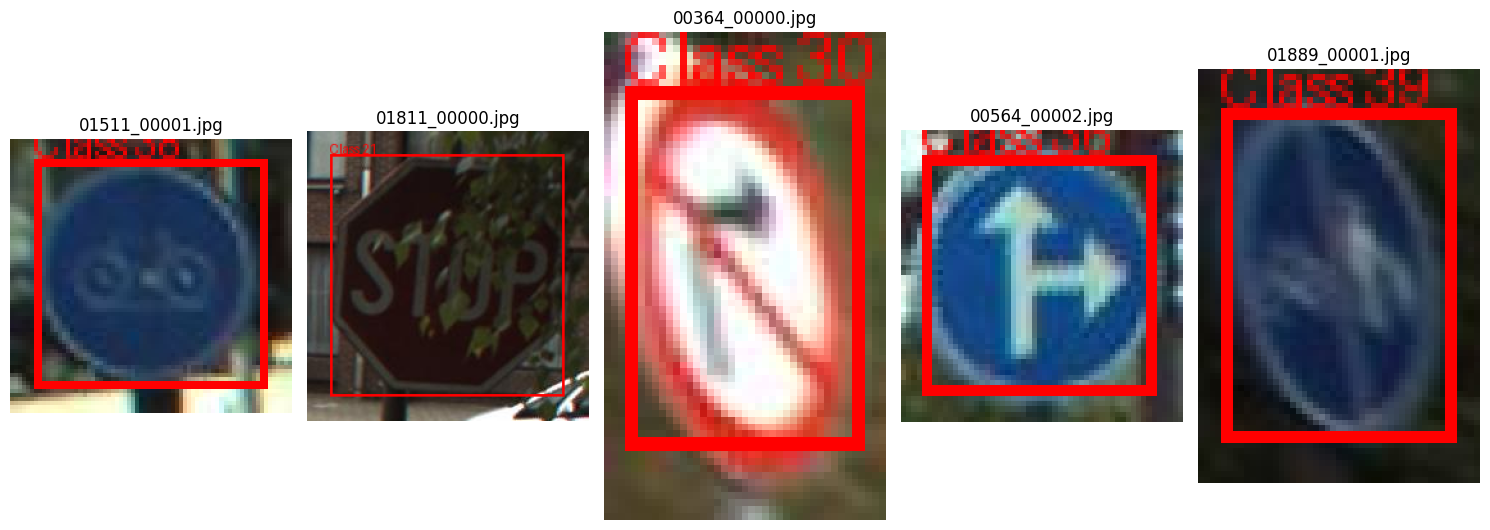

In [37]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import random

# Paths
image_folder = "data/btsd/images/train"
label_folder = "data/btsd/labels/train"

# List all image files
image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]

# Select a few images randomly
num_images = 5
sample_files = random.sample(image_files, min(num_images, len(image_files)))

# Plot images with bounding boxes
plt.figure(figsize=(15, 10))
for i, filename in enumerate(sample_files):
    image_path = os.path.join(image_folder, filename)
    label_path = os.path.join(label_folder, filename.replace(".jpg", ".txt"))

    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Draw bounding boxes if label file exists
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, w, h = map(float, parts[1:])

                # Convert back to pixel coordinates
                x1 = int((x_center - w / 2) * width)
                y1 = int((y_center - h / 2) * height)
                x2 = int((x_center + w / 2) * width)
                y2 = int((y_center + h / 2) * height)

                draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
                draw.text((x1, y1 - 10), f"Class {class_id}", fill="red")

    # Show the image
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(filename)

plt.tight_layout()
plt.show()

## Setup the train file 

Prevent a memory leak by not having to much things to print

In [55]:
import re

train_path = "yolov5/train.py"

with open(train_path, "r") as file:
    code = file.read()

# Remove tqdm progress bar
code = re.sub(r'tqdm\(enumerate\(dataloader\).*?\)', 'enumerate(dataloader)', code)

# Replace verbose printing with a simple epoch print
code = re.sub(
    r'(print\(.*?f.*?Epoch.*?\))',
    'print(f"Epoch {epoch + 1}/{epochs}")',
    code
)

# Optional: update deprecated autocast usage
code = re.sub(r'(with torch\.cuda\.amp\.autocast\(amp\):)', r'with torch.amp.autocast("cuda"):', code)

with open(train_path, "w") as file:
    file.write(code)

print("train.py patched.")

train.py patched.


## Trainig

### First training on GTSDB

In [56]:
# Train YOLOv5 on the German Traffic Sign Detection Benchmark
!python yolov5/train.py \
    --img 640 \
    --batch 16 \
    --epochs 50 \
    --data train_gtsdb.yaml \
    --weights yolov5s.pt \
    --name yolo_gtsdb

train: weights=yolov5s.pt, cfg=, data=train_gtsdb.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolo_gtsdb, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2025-4-18 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epo

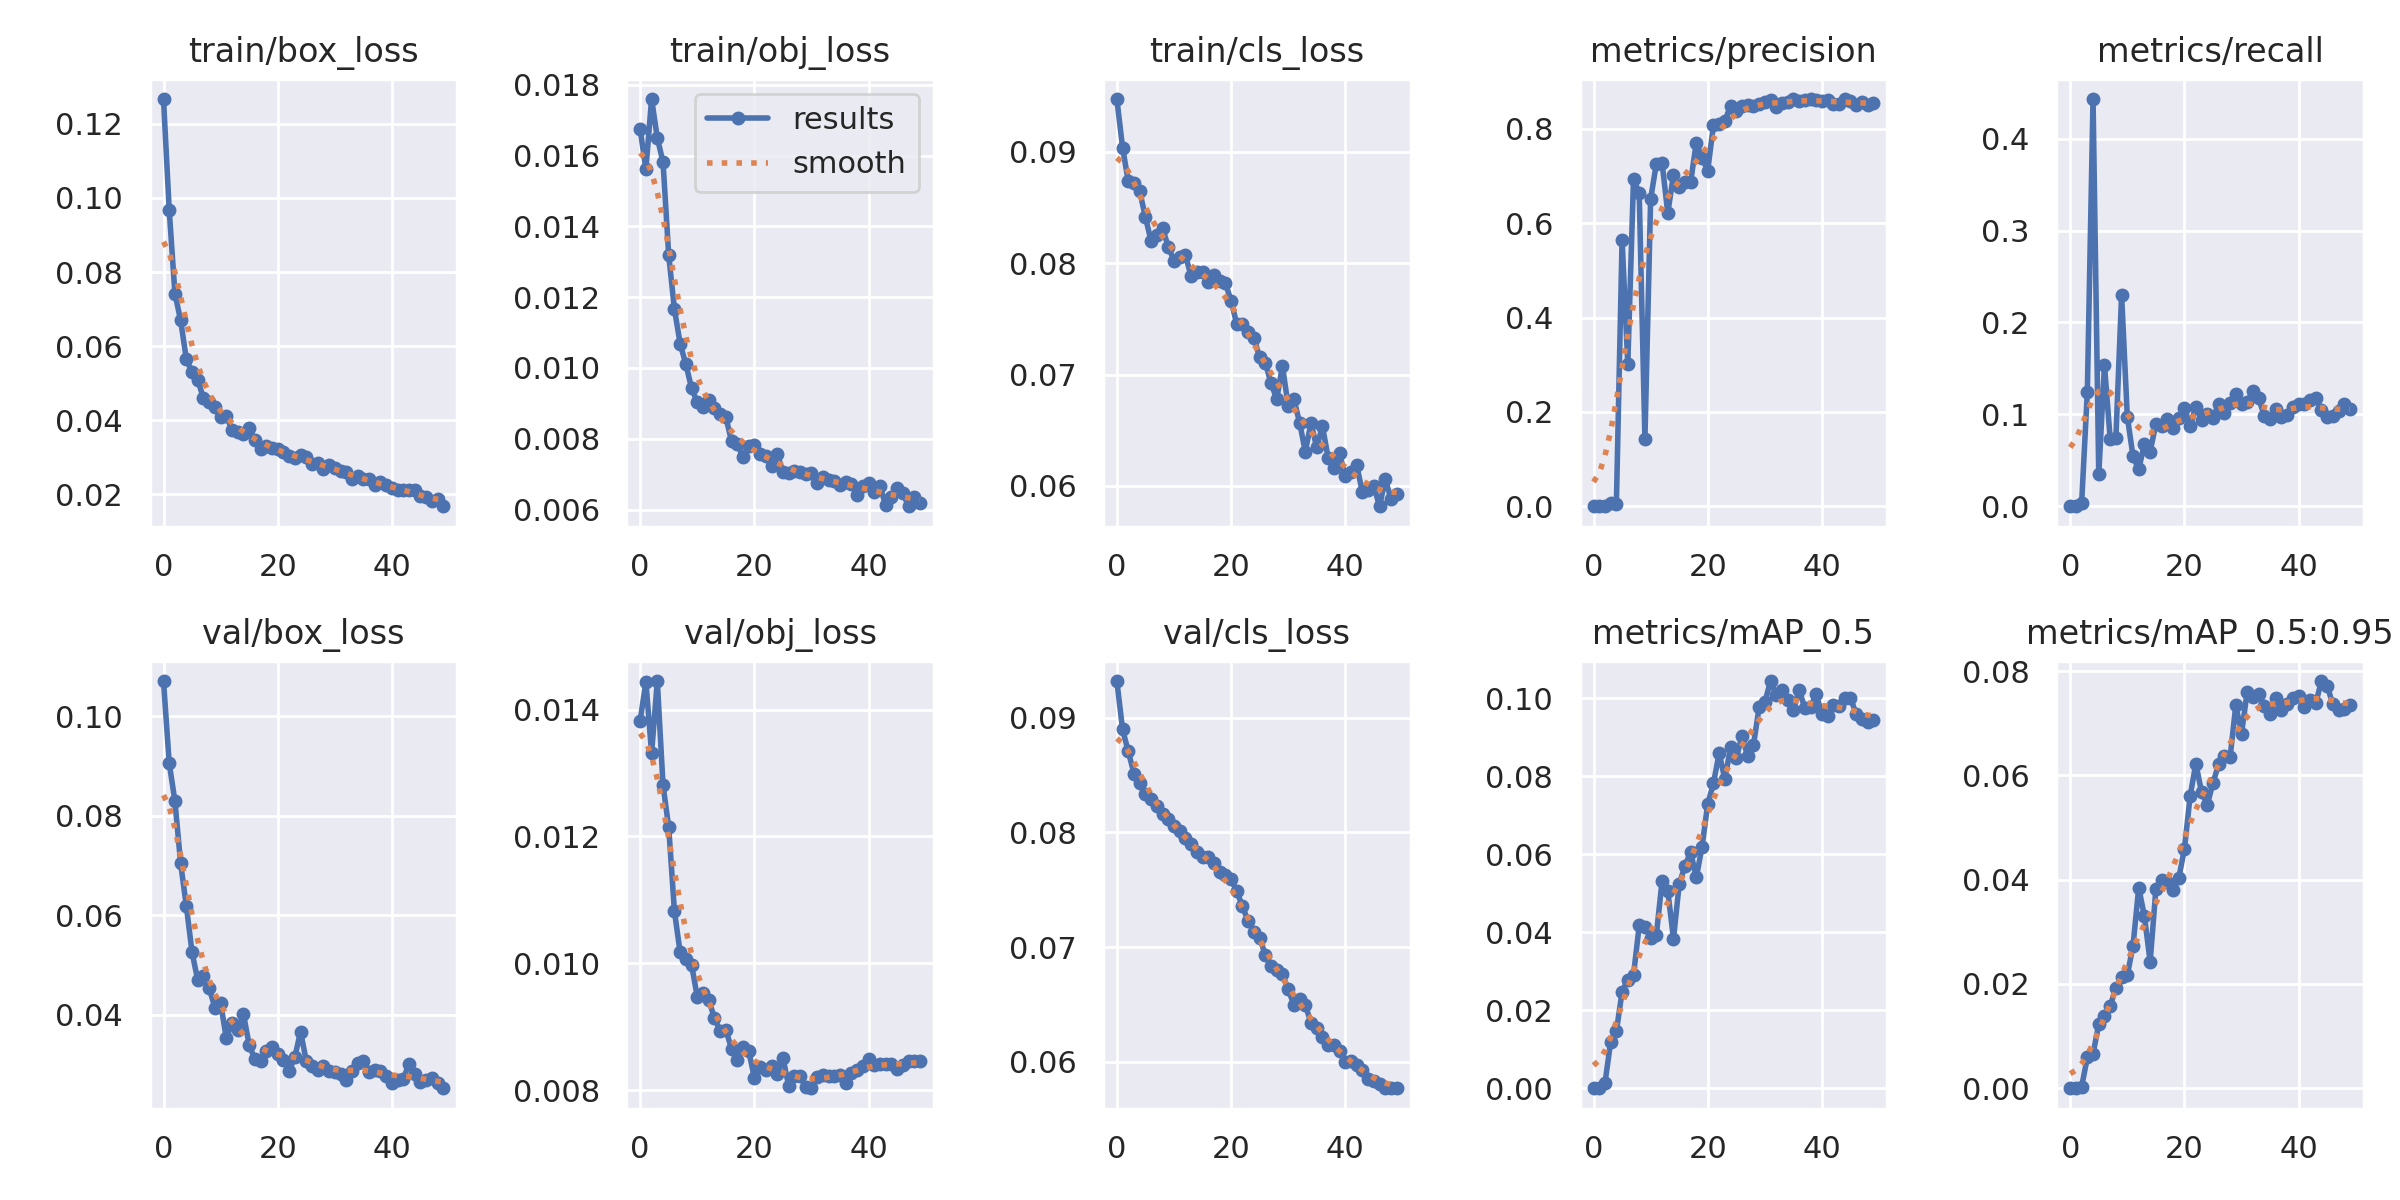

In [57]:
from IPython.display import Image, display
display(Image("yolov5/runs/train/yolo_gtsdb/results.png"))

### Test on GTSDB

In [64]:
!python yolov5/val.py \
  --weights yolov5/runs/train/yolo_gtsdb/weights/best.pt \
  --data train_gtsdb.yaml \
  --img 640 \
  --task val \
  --name test_gtsdb \
  --exist-ok

val: data=train_gtsdb.yaml, weights=['yolov5/runs/train/yolo_gtsdb/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=test_gtsdb, exist_ok=True, half=False, dnn=False
YOLOv5 🚀 2025-4-18 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

Fusing layers... 
Model summary: 157 layers, 7126096 parameters, 0 gradients, 16.1 GFLOPs
val: Scanning /home/gasp/Work_Warsaw/Projet_IAF/data/gtsdb/labels/val.cache... 2
                 Class     Images  Instances          P          R      mAP50   
                   all        218        218      0.863      0.105        0.1     0.0779
        speed limit 20        218          7      0.161      0.571      0.384      0.307
        speed limit 30        218          2          1          0      0.002   0

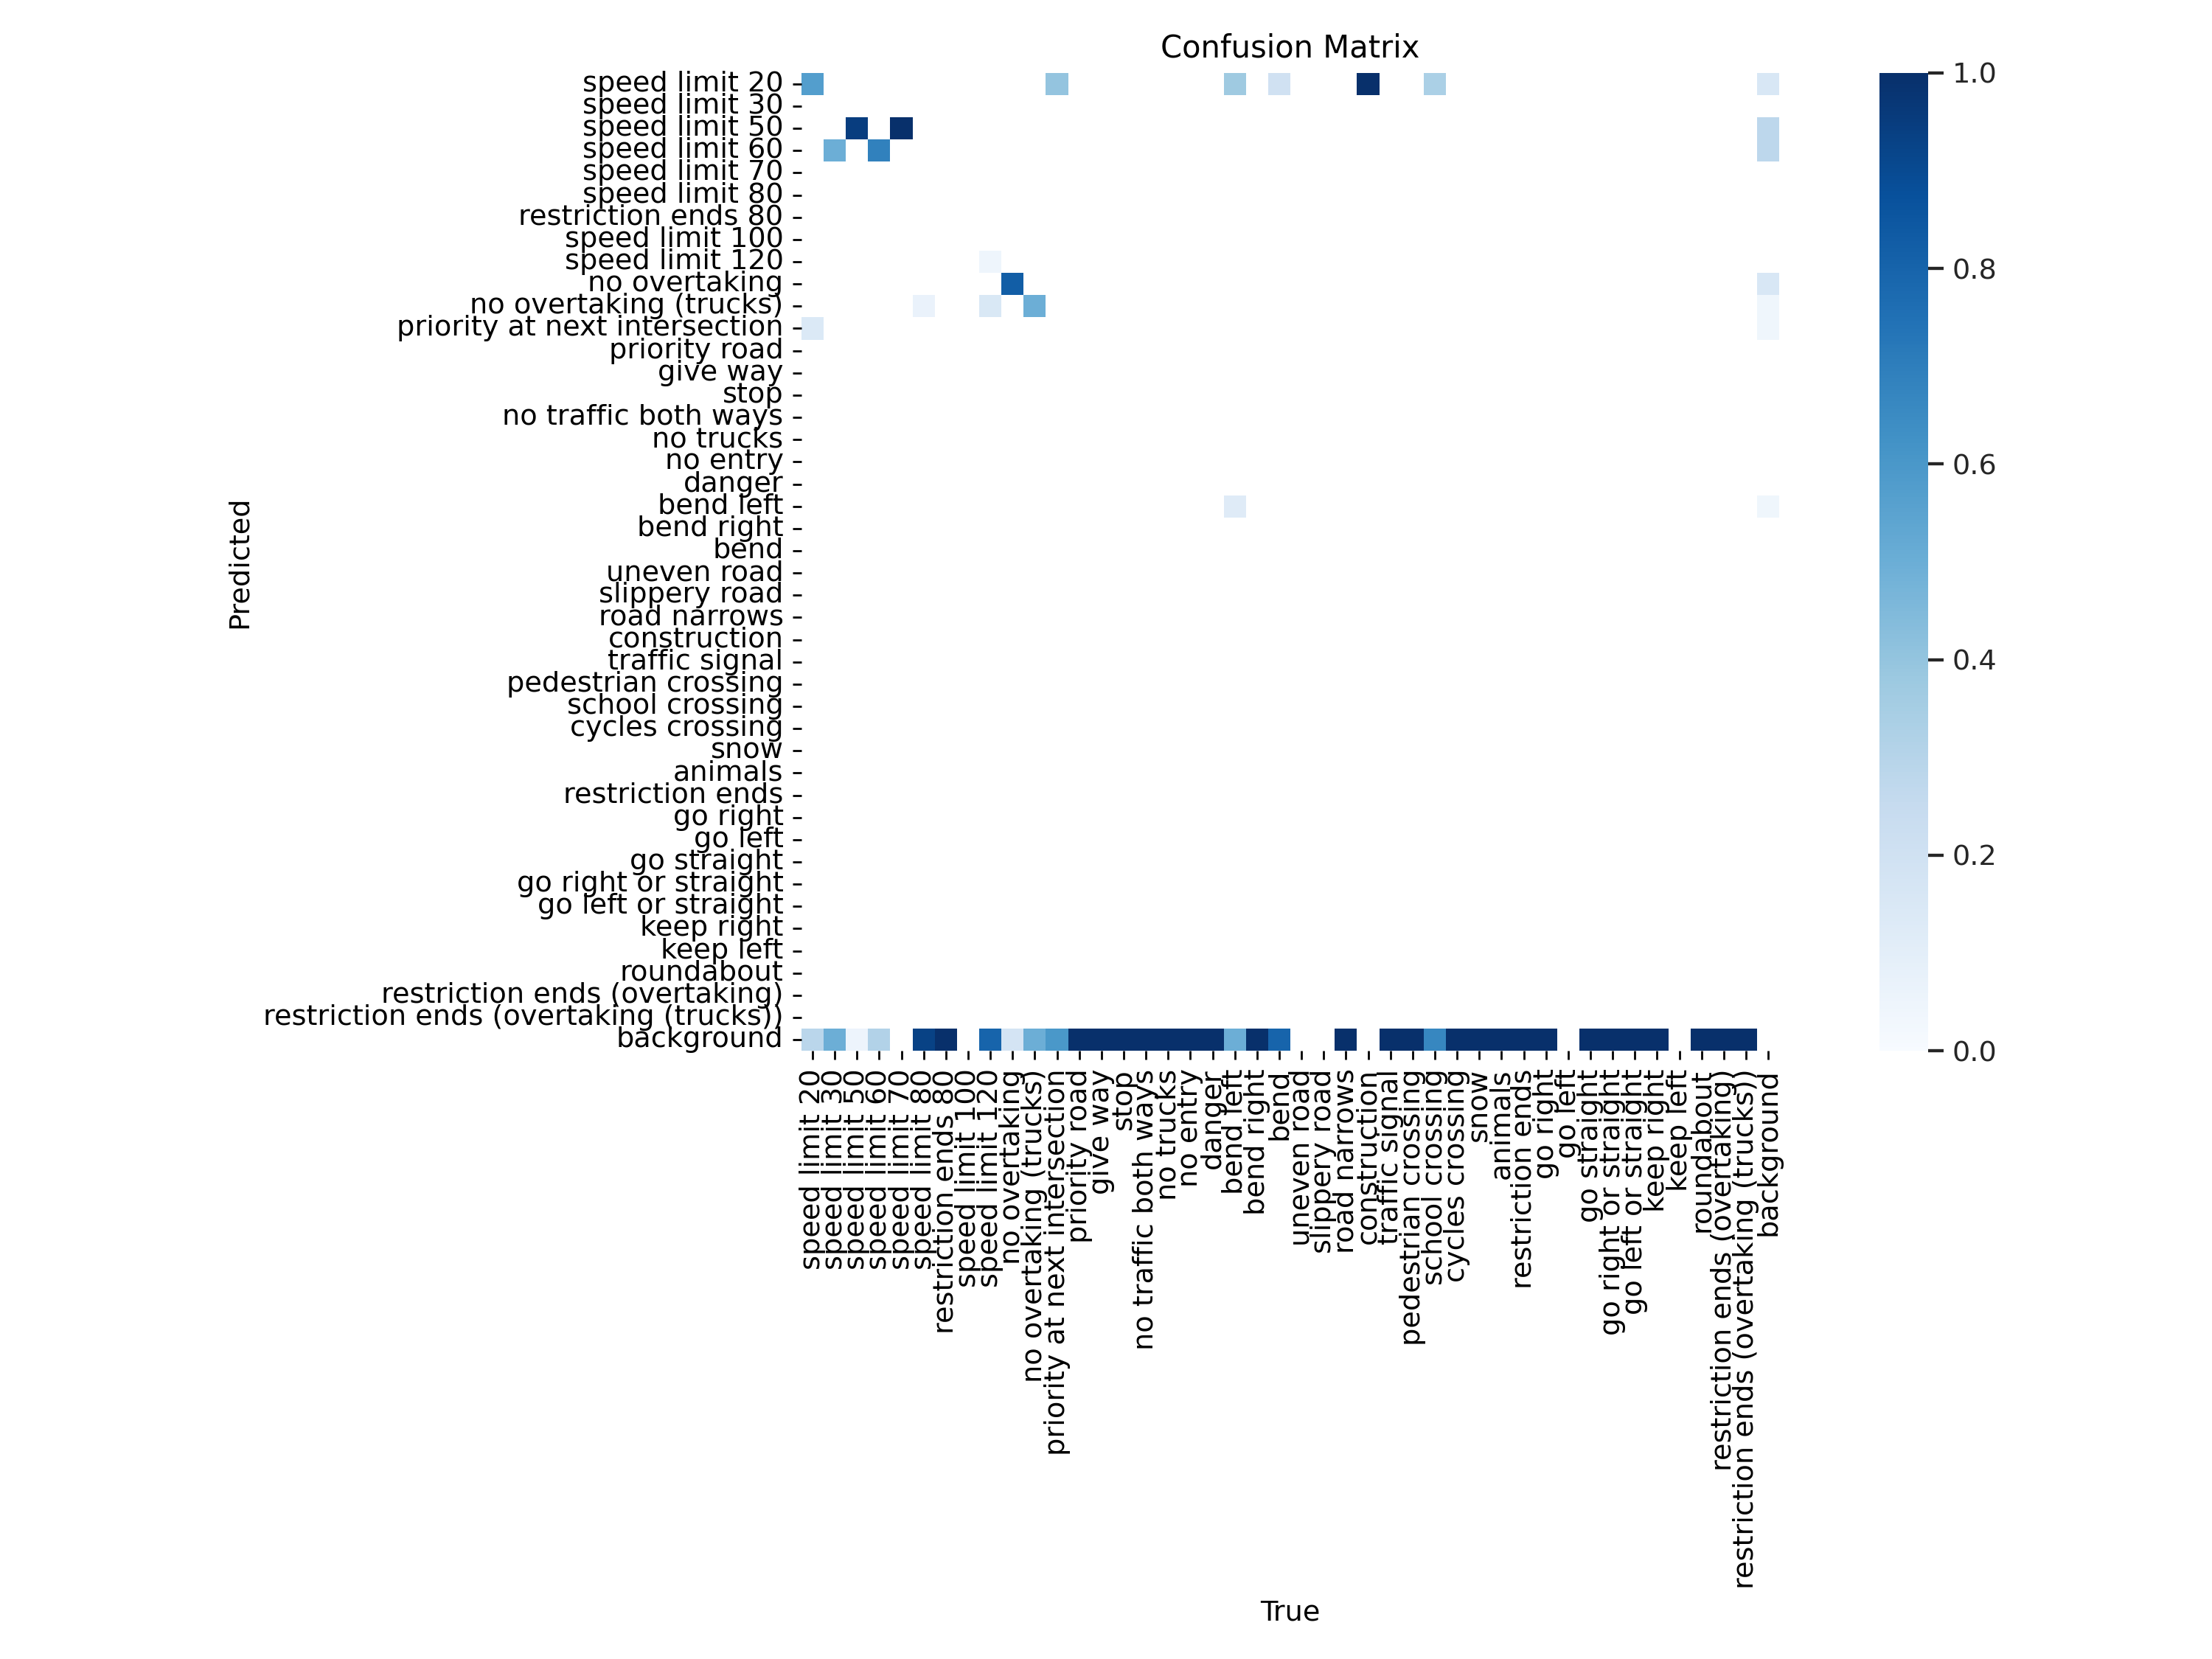

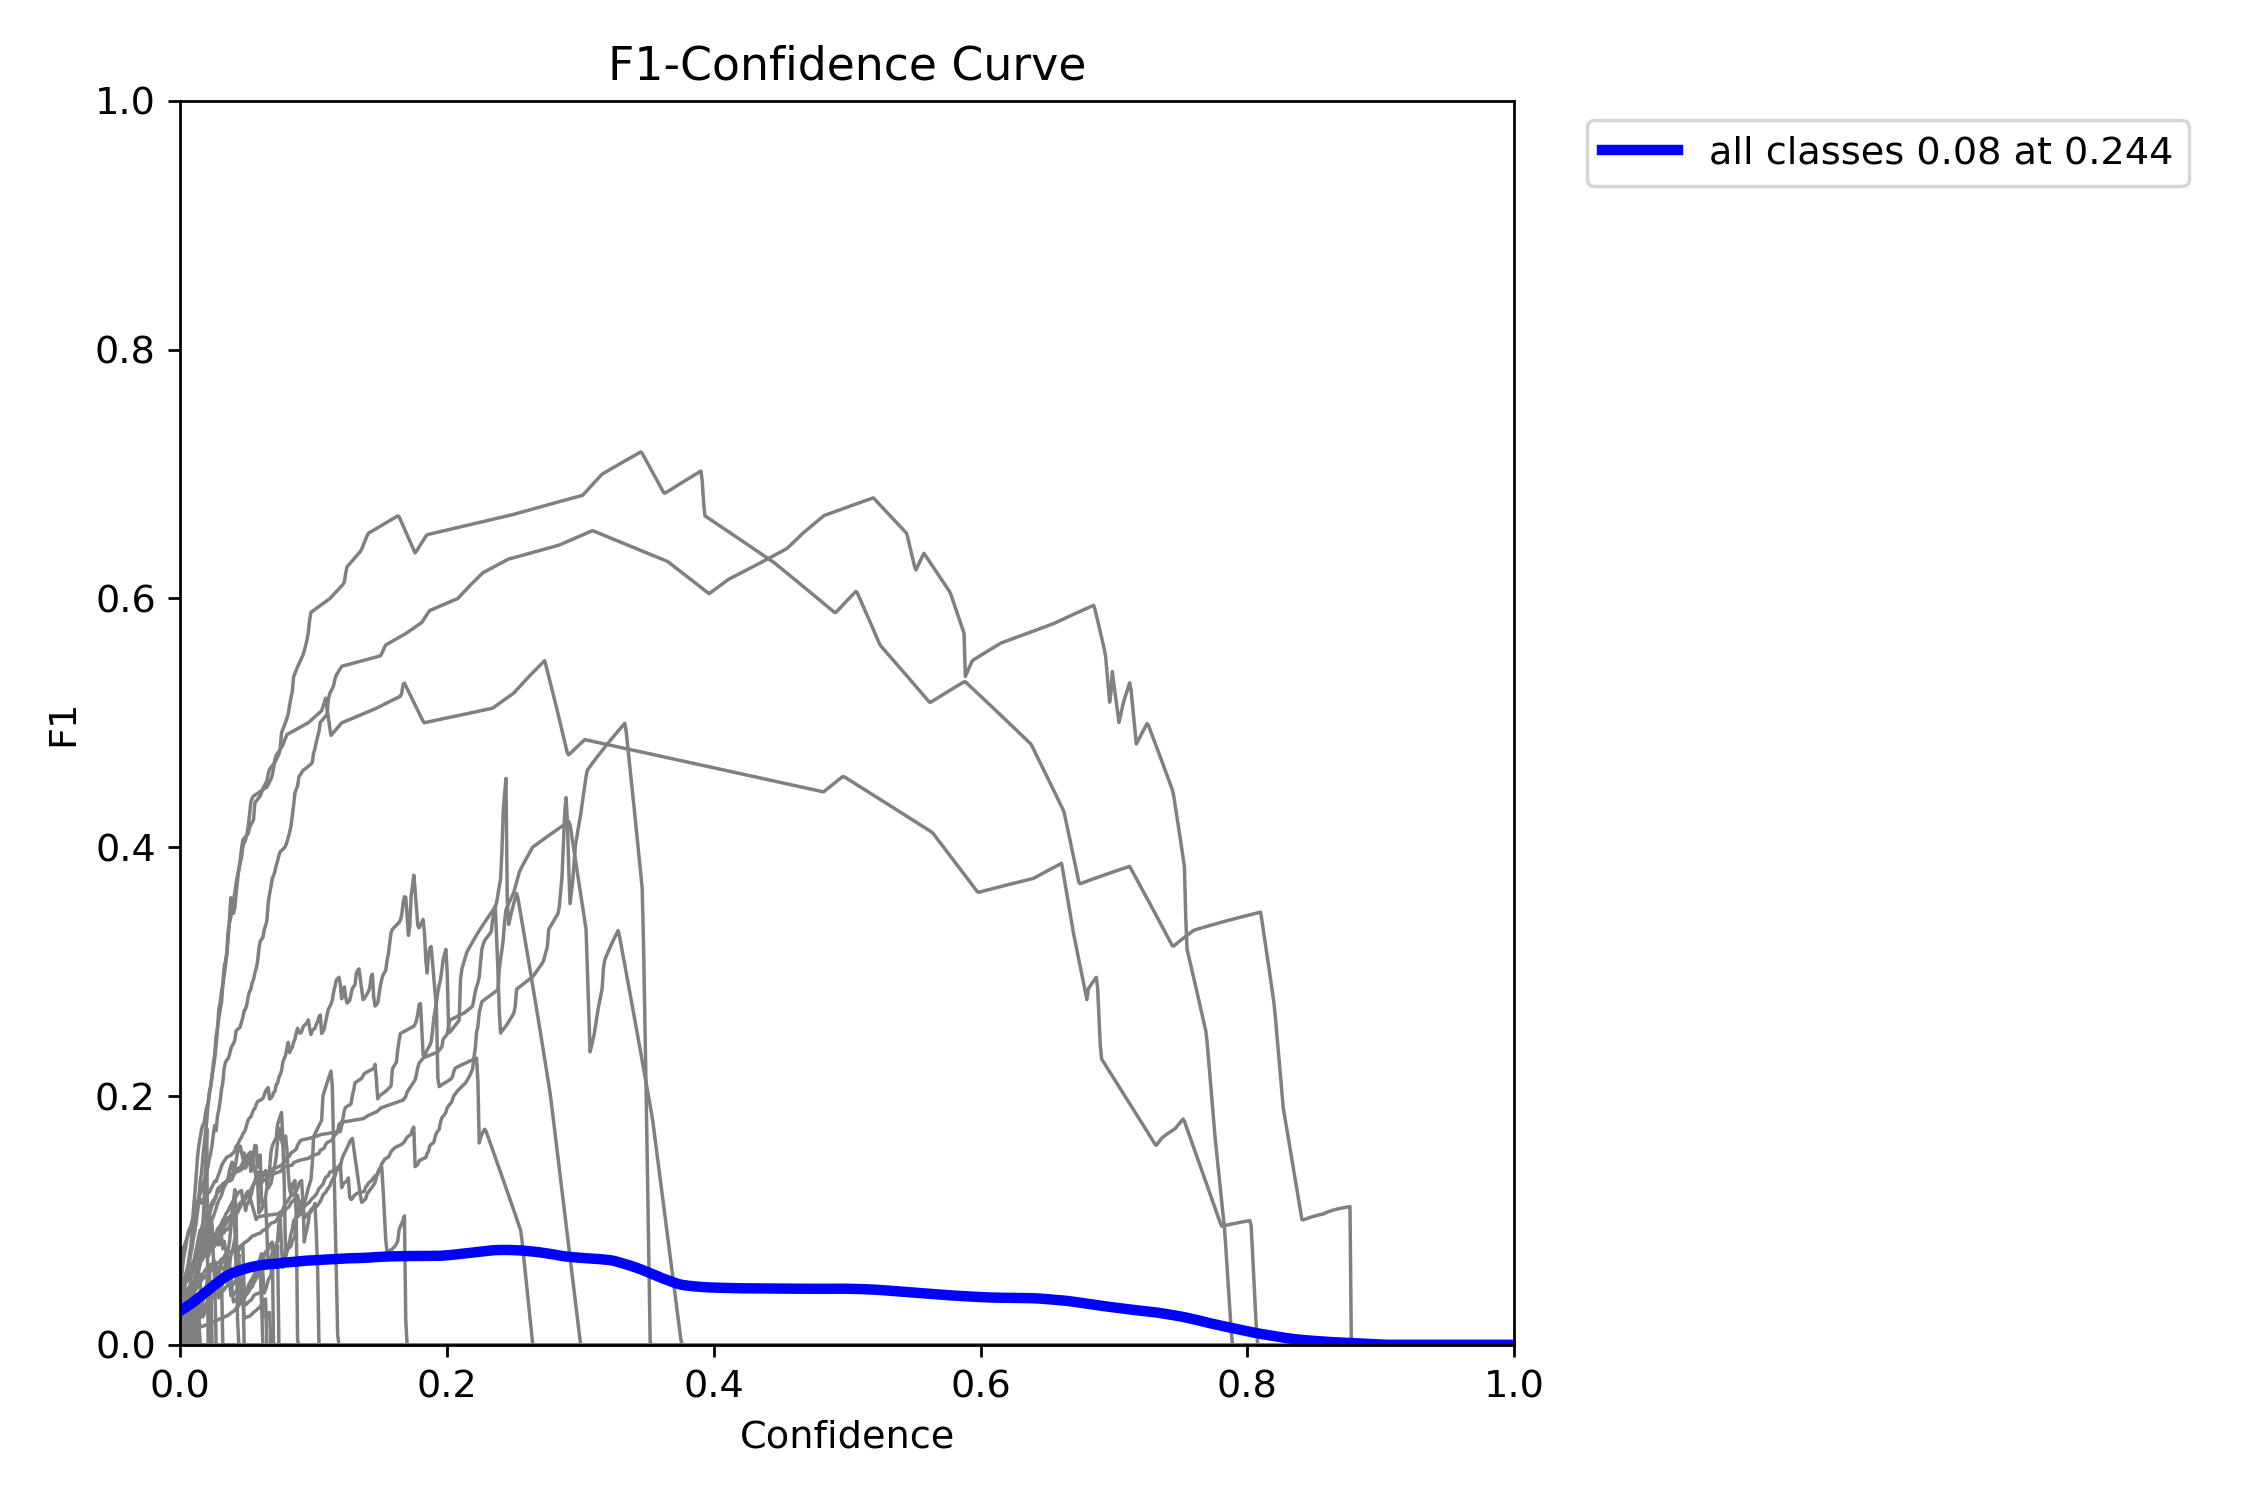

In [65]:
# Visualisation of the test
from IPython.display import Image, display

base_path = "yolov5/runs/val/test_gtsdb/"

# Liste des fichiers à afficher
files_to_show = [
    "confusion_matrix.png",
    "F1_curve.png"
]

for file in files_to_show:
    display(Image(filename=os.path.join(base_path, file)))

### Fine tuning on BTSC

In [66]:
# Fine-tune on the Belgium Traffic Sign Dataset using GTSDB-trained model
!python yolov5/train.py \
    --img 640 \
    --batch 16 \
    --epochs 30 \
    --data train_btsd.yaml \
    --weights yolov5/runs/train/yolo_gtsdb/weights/best.pt \
    --name yolo_gtsdb_btsd

train: weights=yolov5/runs/train/yolo_gtsdb/weights/best.pt, cfg=, data=train_btsd.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolo_gtsdb_btsd, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2025-4-18 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=

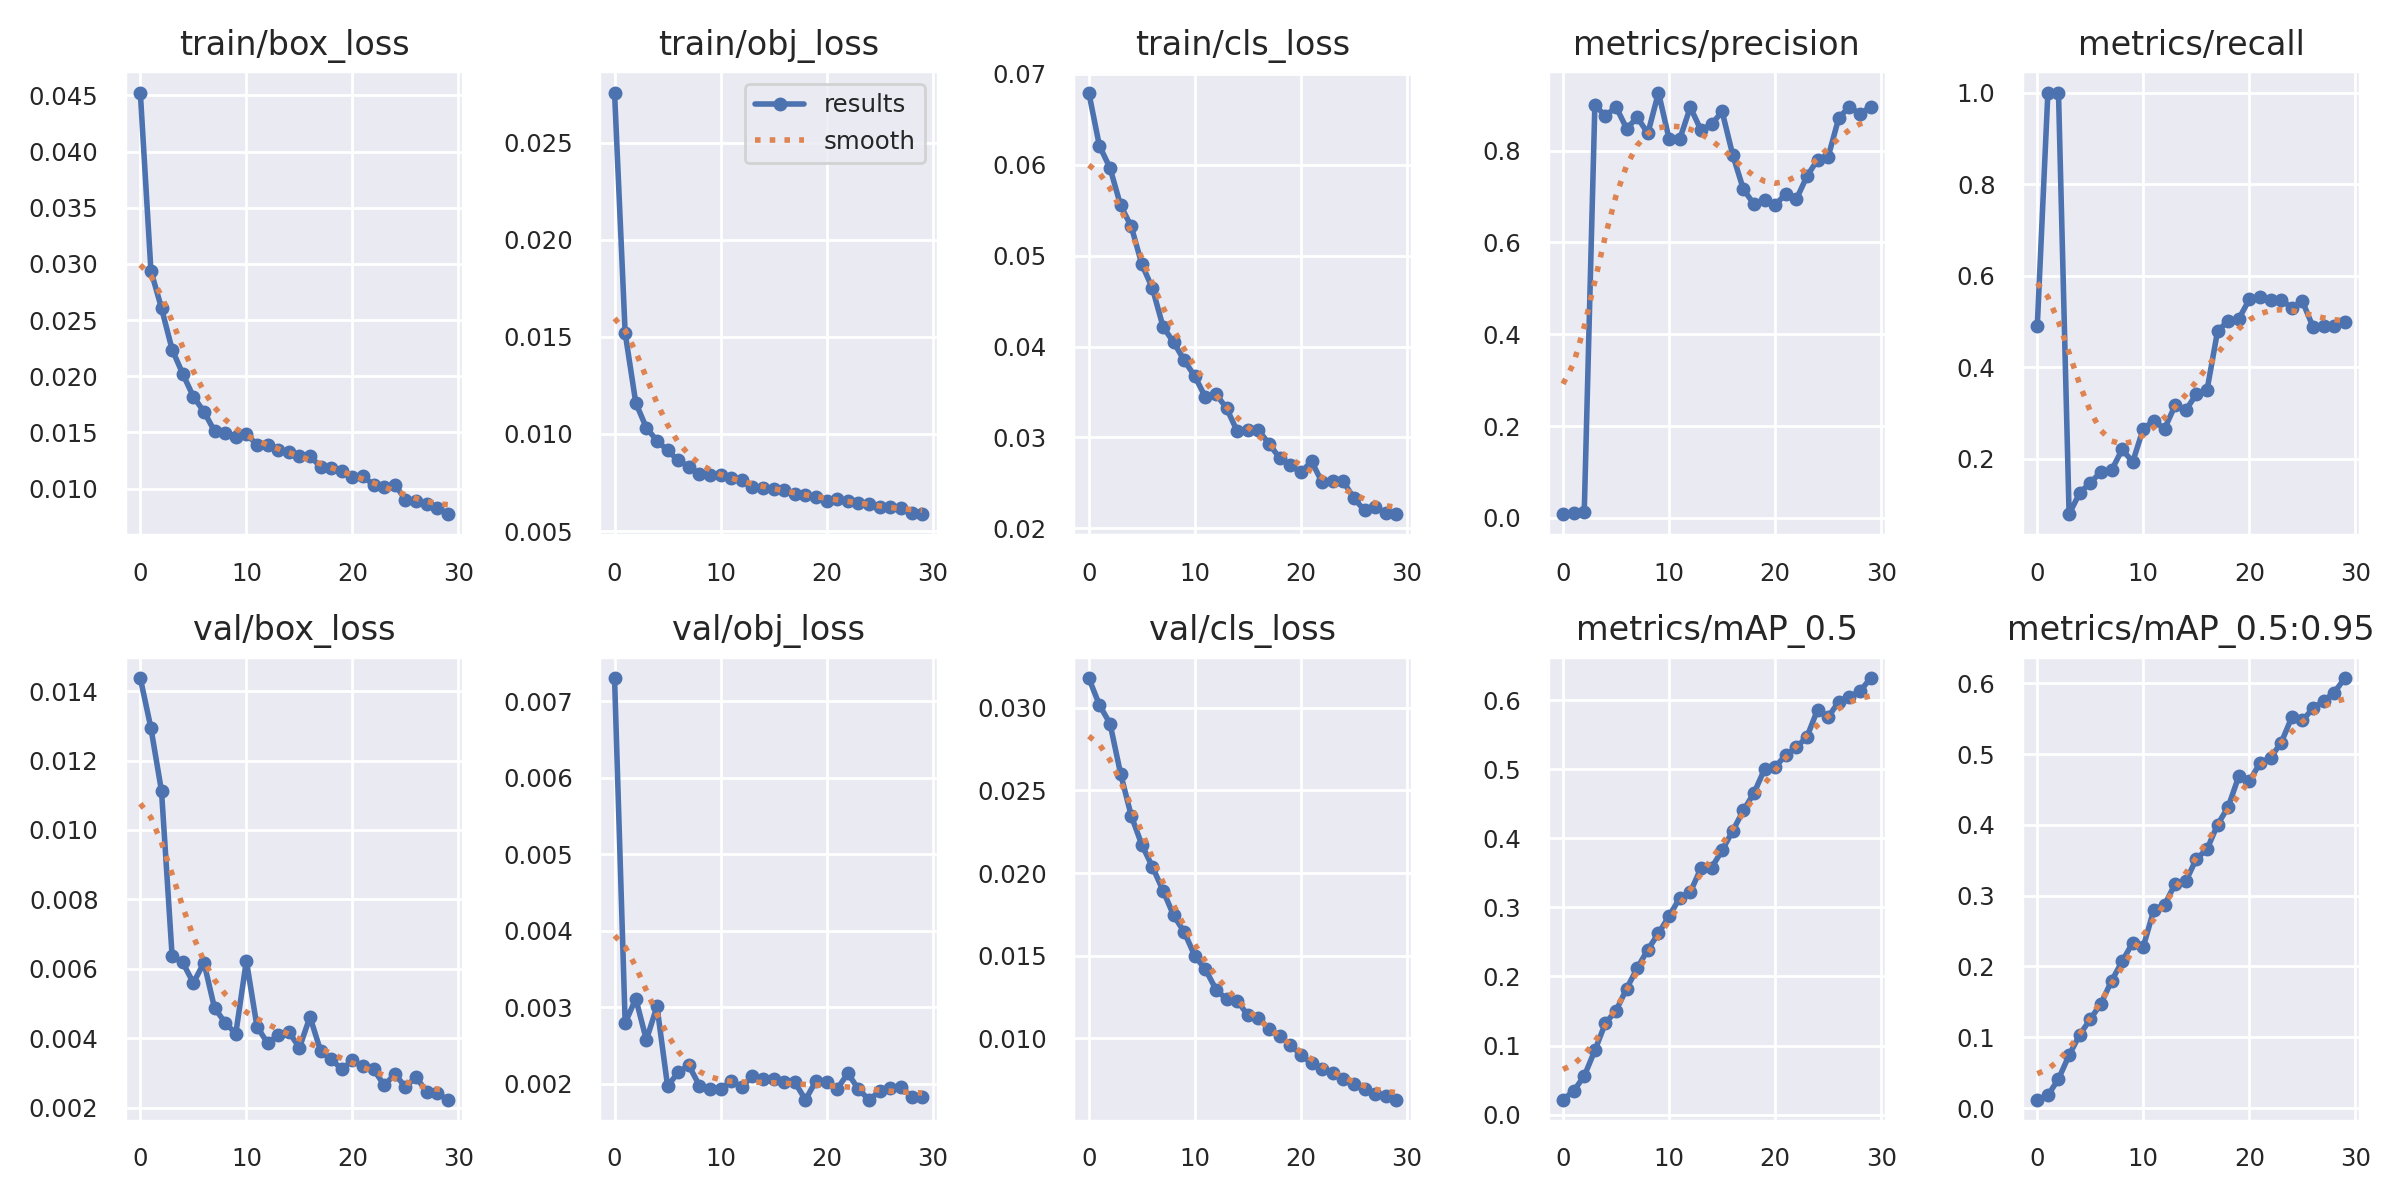

In [67]:
from IPython.display import Image, display
display(Image("yolov5/runs/train/yolo_gtsdb_btsd/results.png"))

### Test of the fine tuned model

In [68]:
!python yolov5/val.py \
  --weights yolov5/runs/train/yolo_gtsdb_btsd/weights/best.pt \
  --data train_btsd.yaml \
  --img 640 \
  --task val \
  --name test_btsd_finetuned \
  --exist-ok

val: data=train_btsd.yaml, weights=['yolov5/runs/train/yolo_gtsdb_btsd/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=test_btsd_finetuned, exist_ok=True, half=False, dnn=False
YOLOv5 🚀 2025-4-18 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

Fusing layers... 
Model summary: 157 layers, 7177339 parameters, 0 gradients, 16.3 GFLOPs
val: Scanning /home/gasp/Work_Warsaw/Projet_IAF/data/btsd/labels/val.cache... 89
                 Class     Images  Instances          P          R      mAP50   
                   all        896        896      0.897      0.499      0.632      0.607
Speed: 0.4ms pre-process, 7.9ms inference, 2.3ms NMS per image at shape (32, 3, 640, 640)
Results saved to yolov5/runs/val/test_btsd_finetuned


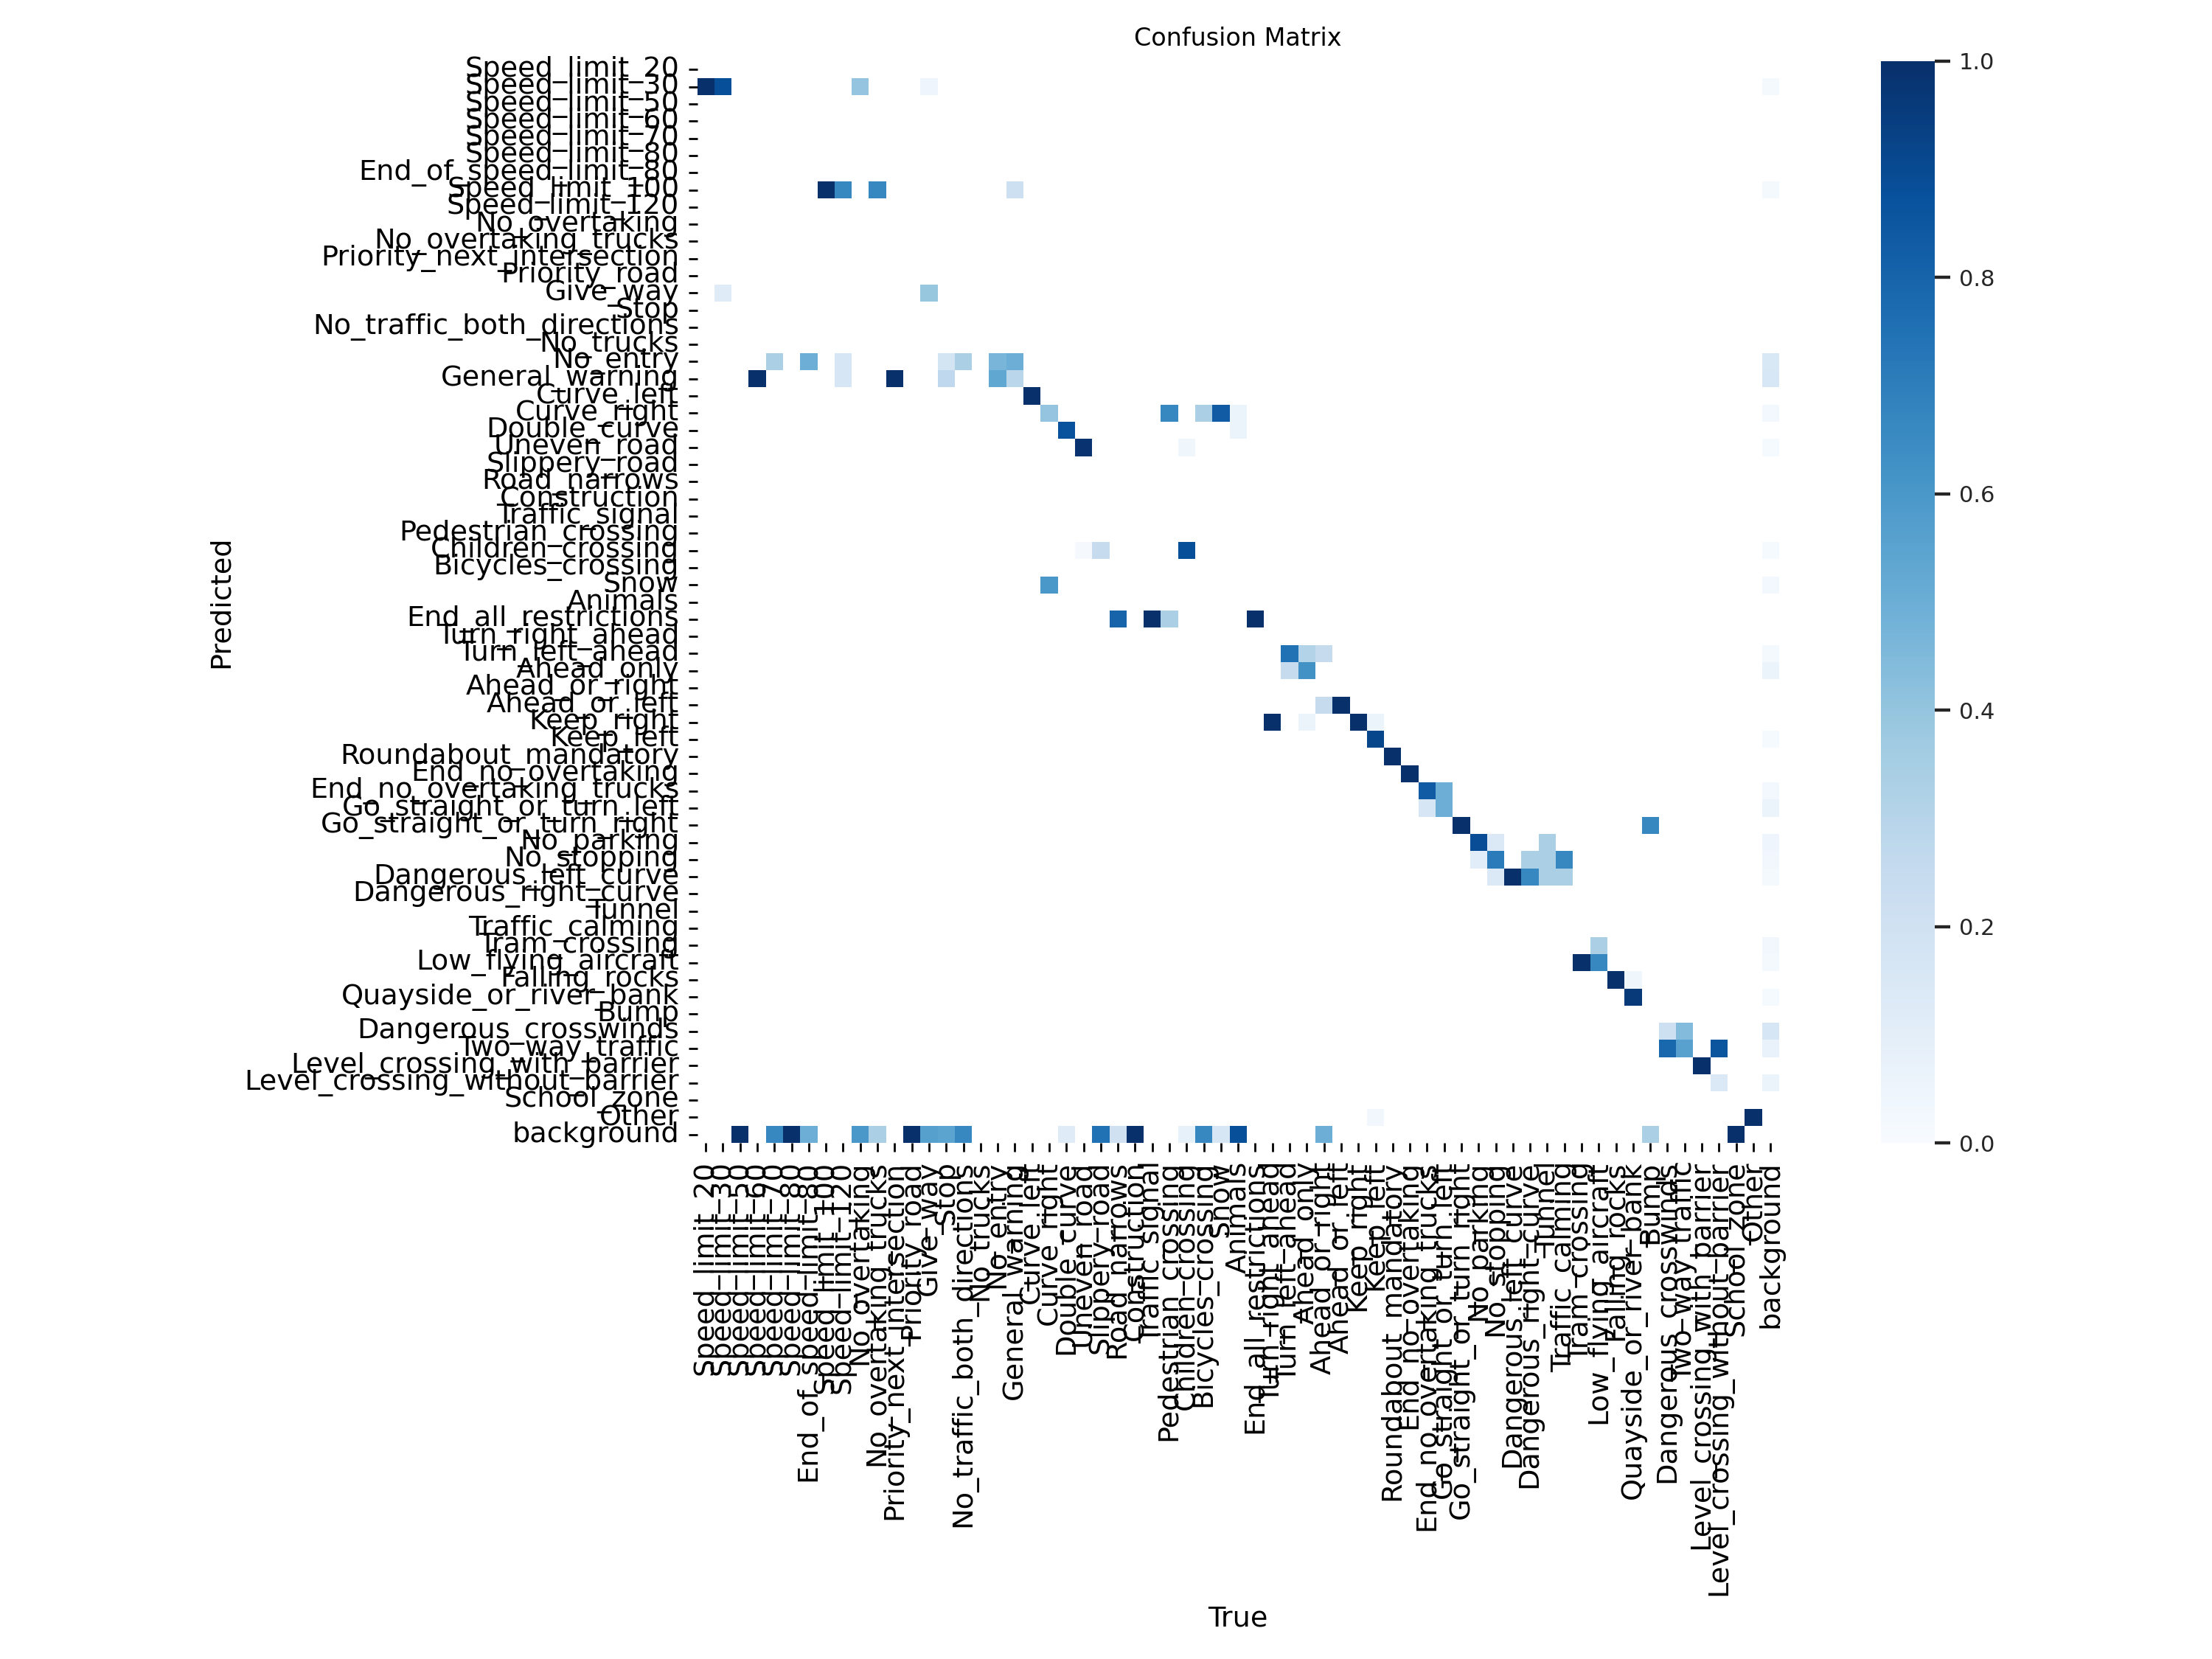

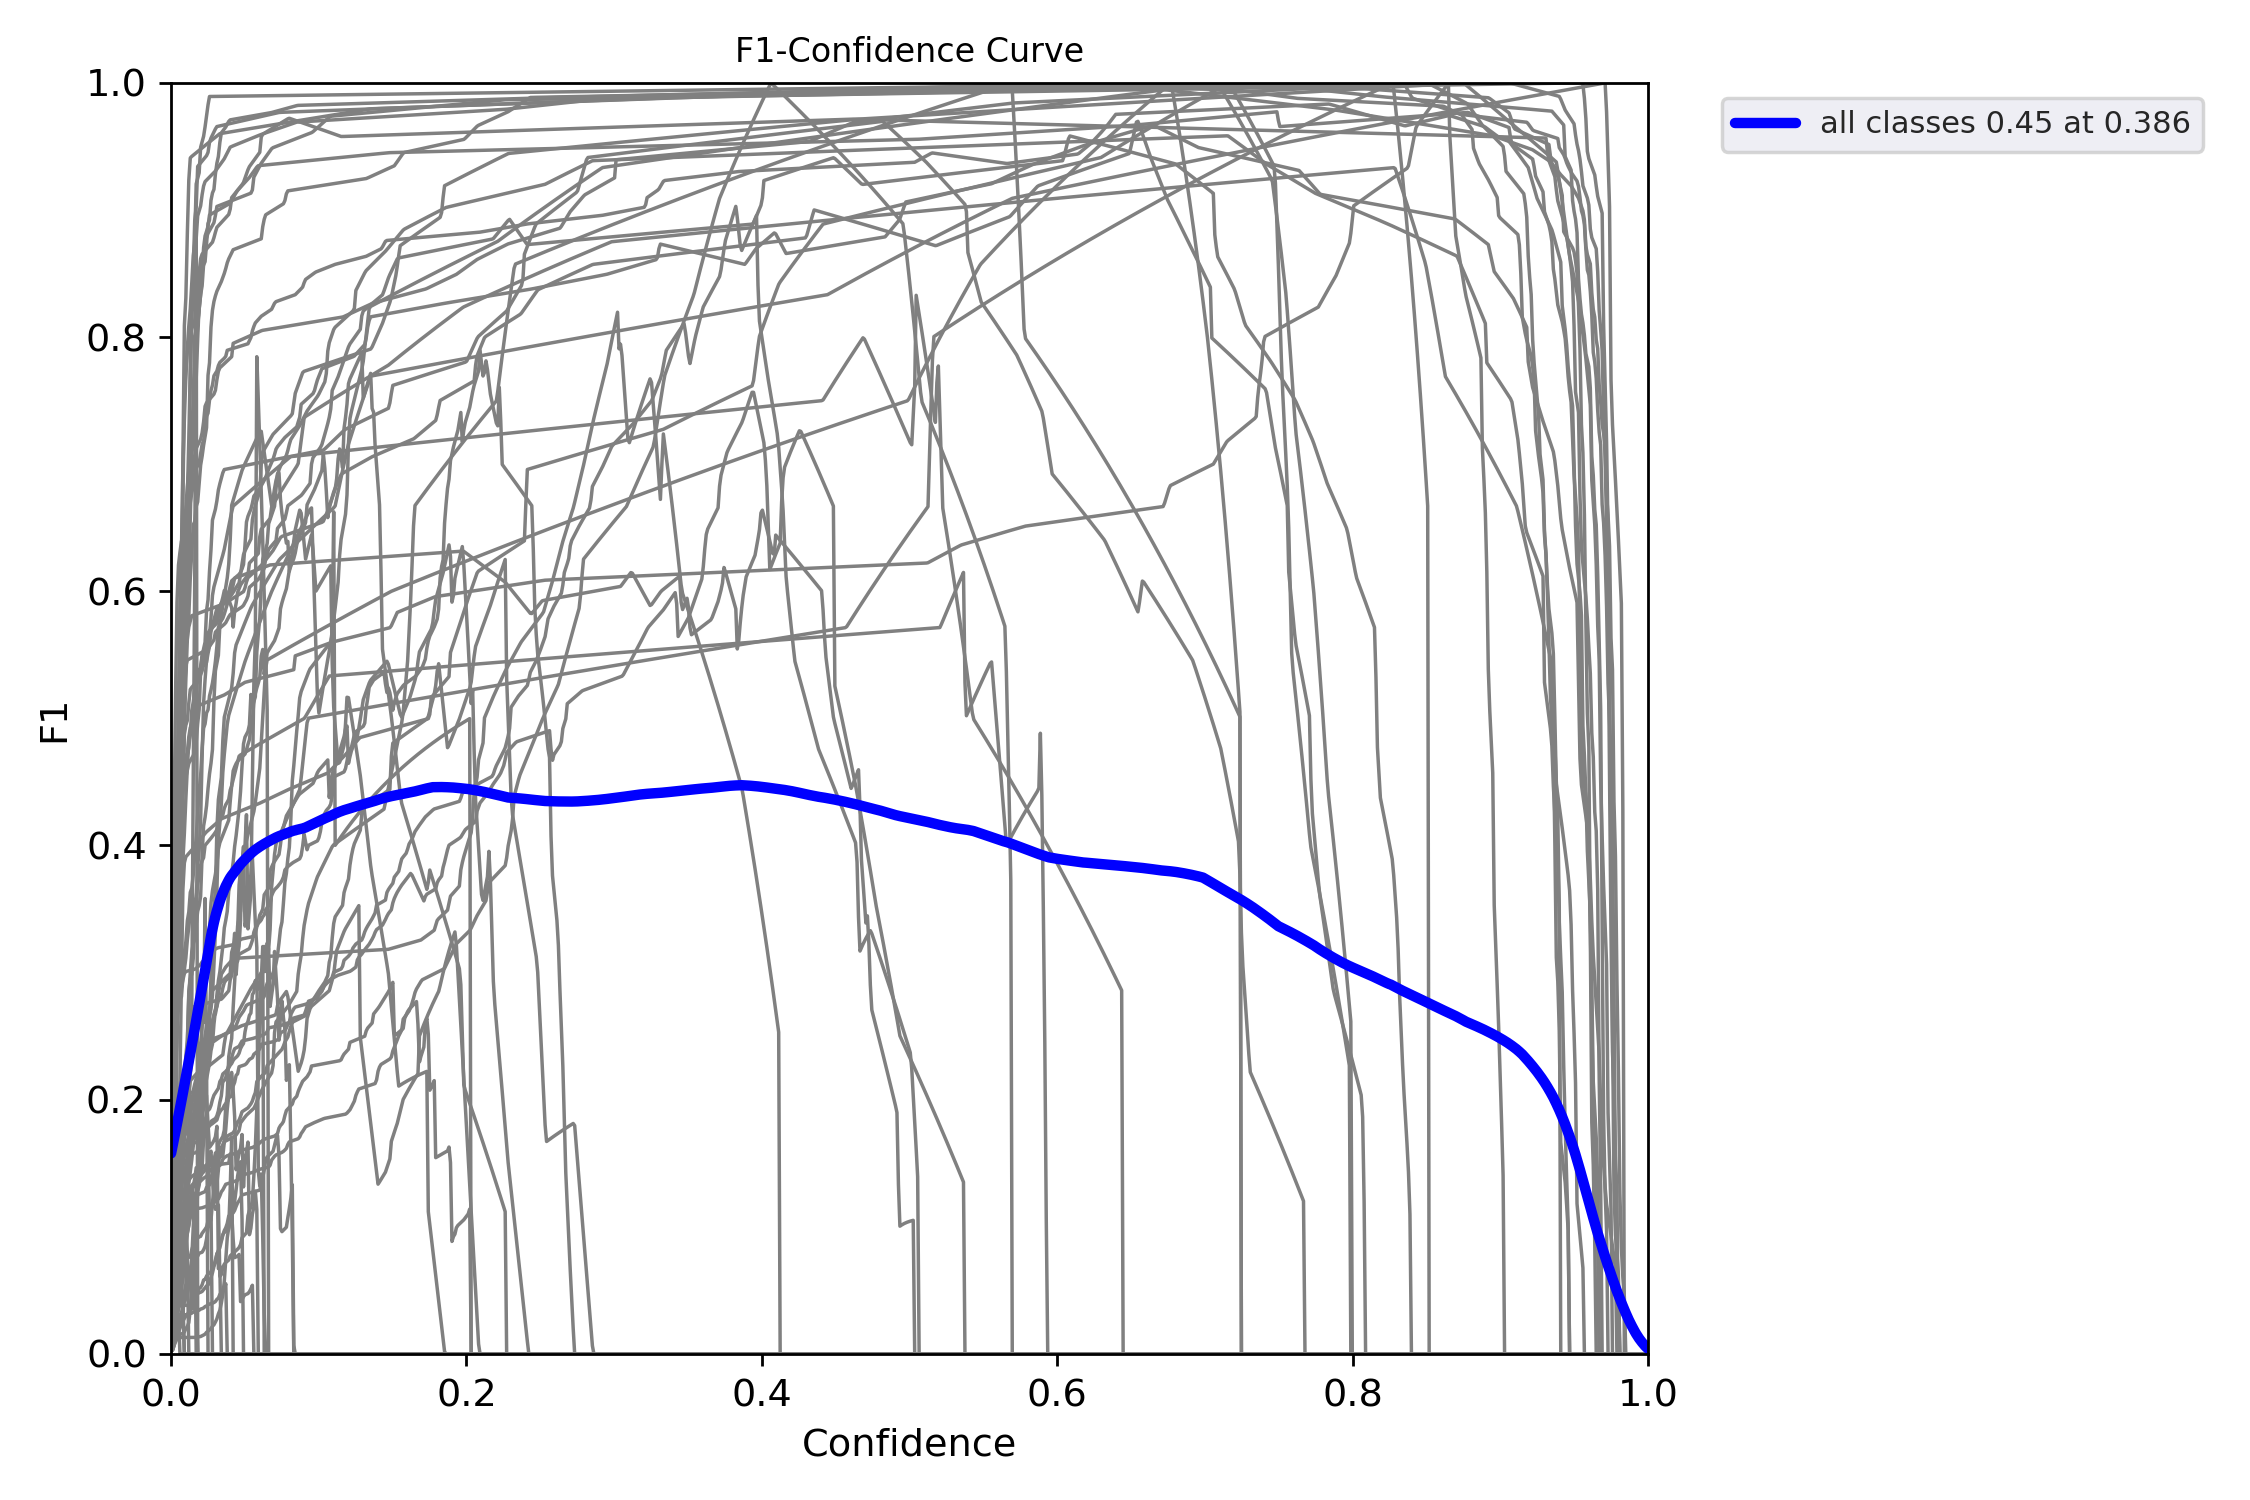

In [70]:
import os
from IPython.display import Image, display

# Dossier contenant les résultats du test
base_path = "yolov5/runs/val/test_btsd_finetuned/"

# Fichiers à afficher
files_to_show = [
    "confusion_matrix.png",
    "F1_curve.png"
]

# Affichage
for file in files_to_show:
    image_path = os.path.join(base_path, file)
    if os.path.exists(image_path):
        display(Image(filename=image_path))
    else:
        print(f"File not found: {image_path}")

## Test on real pictures

In [71]:
!python yolov5/detect.py \
 --weights yolov5/runs/train/yolo_gtsdb_btsd/weights/best.pt \
 --img 1024 \
 --conf 0.1 \
 --augment \
 --source voie-prioritaire.jpg \
 --save-crop \
 --project runs/detect \
 --name panneau_test_finetuned \
 --exist-ok

detect: weights=['yolov5/runs/train/yolo_gtsdb_btsd/weights/best.pt'], source=voie-prioritaire.jpg, data=yolov5/data/coco128.yaml, imgsz=[1024, 1024], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs/detect, name=panneau_test_finetuned, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2025-4-18 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

Fusing layers... 
Model summary: 157 layers, 7177339 parameters, 0 gradients, 16.3 GFLOPs
image 1/1 /home/gasp/Work_Warsaw/Projet_IAF/voie-prioritaire.jpg: 768x1024 (no detections), 105.9ms
Speed: 0.9ms pre-process, 105.9ms inference, 33.6ms NMS per image at shape (1, 3, 1024, 1024)
Results saved to runs/detect/panneau_test_finetuned


In [72]:
from PIL import Image
from IPython.display import display
import os
import glob

# Path to YOLOv5 cropped results from fine-tuned model
crop_base_path = "runs/detect/panneau_test_finetuned/crops"

if not os.path.exists(crop_base_path):
    print("No crops found.")
else:
    for class_name in sorted(os.listdir(crop_base_path)):
        class_folder = os.path.join(crop_base_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        print(f"\n🪧 Class: {class_name}")
        image_paths = glob.glob(os.path.join(class_folder, "*.jpg"))
        
        for img_path in image_paths[:5]:  # Display up to 5 per class
            img = Image.open(img_path)
            display(img)

No crops found.
